In [33]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import  LatentDirichletAllocation
import numpy as np
from bs4 import BeautifulSoup
import re
import xml.sax.saxutils as saxutils
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
import sys
import tensorflow as tf
import matplotlib.pyplot as plt

In [34]:
this = sys.modules[__name__]


nltk.download('punkt')
nltk.download('stopwords')

this.tokenizer = RegexpTokenizer('[\'a-zA-Z]+')
this.lemmatizer = WordNetLemmatizer()
this.vocabulary = []
this.categories = []
this.stop_words = set(stopwords.words('english'))

def generate_categories():
    this.categories = []
    """Generate the list of categories."""
    topics = 'all-topics-strings.lc.txt'

    with open('./reuters21578/' + topics, 'r') as file:
        for category in file.readlines():
            this.categories.append(category.strip().lower())


def vectorize_docs(documents, w2v_model):
    """A weird oneshot representation for word2vec."""
    document_max_num_words = 100
    num_features = 500

    x = np.zeros(shape=(this.number_of_documents, document_max_num_words,
                        num_features)).astype(np.float32)

    empty_word = np.zeros(num_features).astype(np.float32)

    for idx, document in enumerate(documents):
        for jdx, word in enumerate(document):
            if jdx == document_max_num_words:
                break

            else:
                if word in w2v_model:
                    x[idx, jdx, :] = w2v_model[word]
                else:
                    x[idx, jdx, :] = empty_word

    return x


def vectorize_categories(categories):
    num_categories = len(this.categories)

    y = np.zeros(shape=(this.number_of_documents, num_categories)).astype(np.float32)

    for idx, key in enumerate(categories.keys()):
        y[idx, :] = categories[key]

    return y


def unescape(text):
    """Unescape charactes."""
    return saxutils.unescape(text)


def unique(arr):
    return list(set(arr))


def add_to_vocab(elements):
    for element in elements:
        if element not in this.vocabulary:
            this.vocabulary.append(element)


def add_to_categories(elements):
    for element in elements:
        if element not in this.categories:
            this.categories.append(element)


def transform_to_indices(elements):
    res = []
    for element in elements:
        res.append(this.vocabulary.index(element))
    return res


def transform_to_category_indices(element):
    return this.categories.index(element)


def strip_tags(text):
    """String tags for a better vocabulary."""
    return re.sub('<[^<]+?>', '', text).strip()


def to_category_onehot(categories):
    """Create onehot vectors for categories."""
    target_categories = this.categories
    vector = np.zeros(len(target_categories)).astype(np.float32)

    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0

    return vector

def read_retuters_files(path="./reuters21578/"):
    x_train = {}
    x_test = {}
    y_train = {}
    y_test = {}

    for file in os.listdir(path):
        if file.endswith(".sgm"):
            print("reading ", path + file)
            f = open(path + file, 'r')
            data = f.read()

            soup = BeautifulSoup(data)
            posts = soup.findAll("reuters")
            
            
            for post in posts:
                post_id = post['newid']
                body = unescape(strip_tags(str(post('text')))
                                .replace('reuter\n&#3;', ''))
                post_categories = []

                topics = post.topics.contents

                for topic in topics:
                    post_categories.append(strip_tags(str(topic)))

                category_onehot = to_category_onehot(post_categories)
                
                cross_validation_type = post["lewissplit"]
                if (cross_validation_type == "TRAIN"):
                    x_train[post_id] = body
                    y_train[post_id] = category_onehot
                else:
                    x_test[post_id] = body
                    y_test[post_id] = category_onehot
            
    return (x_train, y_train), (x_test, y_test)

def tokenize(document):
    words = []

    for sentence in sent_tokenize(document):
        tokens = [this.lemmatizer.lemmatize(t.lower()) for t in this.tokenizer.tokenize(sentence)
                  if t.lower() not in this.stop_words]
        words += tokens

    return words


def tokenize_docs(document):
    tokenized_docs = []
    this.number_of_documents = len(document)

    for key in document.keys():
        tokenized_docs.append(tokenize(document[key]))

    return tokenized_docs

[nltk_data] Downloading package punkt to /Users/gobidasu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gobidasu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
generate_categories()
(x_train, y_train), (x_test, y_test) = read_retuters_files()



('reading ', './reuters21578/reut2-004.sgm')
('reading ', './reuters21578/reut2-010.sgm')
('reading ', './reuters21578/reut2-011.sgm')
('reading ', './reuters21578/reut2-005.sgm')
('reading ', './reuters21578/reut2-013.sgm')
('reading ', './reuters21578/reut2-007.sgm')
('reading ', './reuters21578/reut2-006.sgm')
('reading ', './reuters21578/reut2-012.sgm')
('reading ', './reuters21578/reut2-016.sgm')
('reading ', './reuters21578/reut2-002.sgm')
('reading ', './reuters21578/reut2-003.sgm')
('reading ', './reuters21578/reut2-017.sgm')
('reading ', './reuters21578/reut2-001.sgm')
('reading ', './reuters21578/reut2-015.sgm')
('reading ', './reuters21578/reut2-014.sgm')
('reading ', './reuters21578/reut2-000.sgm')
('reading ', './reuters21578/reut2-019.sgm')
('reading ', './reuters21578/reut2-018.sgm')
('reading ', './reuters21578/reut2-020.sgm')
('reading ', './reuters21578/reut2-008.sgm')
('reading ', './reuters21578/reut2-009.sgm')
('reading ', './reuters21578/reut2-021.sgm')


In [36]:
nltk.download("wordnet")
 # wordnet
num_features = 500



[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gobidasu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
x_train_token = tokenize_docs(x_train)

w2v_model = Word2Vec(x_train_token,
                     size=num_features,
                     min_count=1,
                     window=10)
w2v_model.init_sims(replace=True)

x_train = vectorize_docs(x_train_token, w2v_model)
y_train = vectorize_categories(y_train)


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [38]:
x_test_token = tokenize_docs(x_test)

w2v_model = Word2Vec(x_test_token,
                         size=num_features,
                         min_count=1,
                         window=10)

w2v_model.init_sims(replace=True)
x_test = vectorize_docs(x_test_token, w2v_model)
y_test = vectorize_categories(y_test)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:39: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [43]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

indices = np.random.permutation(x_test.shape[0])
dev_idx, test_idx = indices[:3455], indices[3455:]

x_dev = x_test[dev_idx, :, :]
x_test = x_test[test_idx, :, :]
y_dev = y_test[dev_idx, :]
y_test = y_test[test_idx, :]
print(x_train.shape, y_train.shape, x_dev.shape, y_dev.shape, x_test.shape, y_test.shape)


((14668, 100, 500), (14668, 135), (6910, 100, 500), (6910, 135))
((14668, 100, 500), (14668, 135), (3455, 100, 500), (3455, 135), (3455, 100, 500), (3455, 135))


In [ ]:
#LSTM  code 

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
import sys

this = sys.modules[__name__]


def lstm(X_train, Y_train, X_dev, Y_dev, X_test, Y_test):
    """Create the LSTM model."""
    
    # tune hyperparams in loop
    document_max_num_words = 100
    num_features = 500
    num_categories = 135

    tb_callback = keras.callbacks.TensorBoard(log_dir='./tb', histogram_freq=0,
                                              write_graph=True, write_images=True)

    model = Sequential()

    model.add(LSTM(document_max_num_words*2 , input_shape=(document_max_num_words,num_features)))
    model.add(Dropout(0.3))
    model.add(Dense(num_categories))
    model.add(Activation('softmax'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, Y_train, batch_size=128, nb_epoch=3,
               callbacks=[tb_callback])

    model.save('lstm_reuters.h5')

    # eval on dev 
    score, acc = model.evaluate(X_dev, Y_dev, batch_size=128)
    
    
    # test on test 
    score, acc = model.evaluate(X_test, Y_test, batch_size=128)

    print('Score: %1.4f' % score)
    print('Accuracy: %1.4f' % acc)

lstm(x_train, y_train, x_dev, y_dev, x_test, y_test)


In [ ]:
x_train = np.reshape(x_train, [14668, 50000])
x_test = np.reshape(x_test, [6910, 50000])

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

In [ ]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
X = tf.placeholder(tf.float32, [None, 50000])
Y = tf.placeholder(tf.float32, [None, 135 ])

# Define parameters W and b of your model
W1 = tf.get_variable("W111", shape=[50000, 50], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.zeros([50]))
W2 = tf.get_variable("W112", shape=[50, 135], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.zeros([135]))

# Define your model's tensorflow graph
Z1 = tf.matmul(X,W1) + b1
A1 = tf.nn.relu(Z1)
Z2 = tf.matmul(A1,W2) + b2
A2 = tf.nn.softmax(Z2)

# Compute the cost function
cross_entropy_cost = -tf.reduce_sum(Y * tf.log(A2))

# Define accuracy metric
num_correct = tf.equal(tf.argmax(A2,1), tf.argmax(Y,1))
num_correct = tf.cast(num_correct, tf.float32)
accuracy = tf.reduce_mean(num_correct)

# Define optimization method, learning rate and the the training step
optimizer = tf.train.AdamOptimizer(0.00005)
train_step = optimizer.minimize(cross_entropy_cost)

# Initialize the variables of the graph, create tensorflow session and run the initialization of global variables.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

costs = []
# Implement the Optimization Loop for 100 iterations
for i in range(20000):
    # Load batch of images and labels
    batch_X, batch_Y = next_batch(100, x_train, y_train)
    # Create feed dictionary
    feed_dict={X: batch_X, Y: batch_Y}
    # Run the session train
    _, cost = sess.run([train_step, cross_entropy_cost], feed_dict=feed_dict)
    # Print cost and iteration
    if i % 1000 == 0:
        print("Iteration: " + str(i) + ", training cost = " + str(cost))
        costs.append(cost)



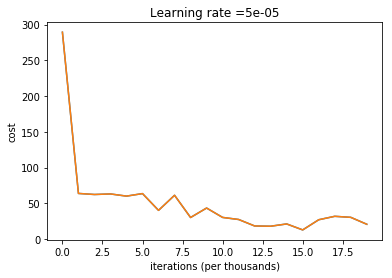

Train accuracy = 0.659122, Train cost = 3381.9
Test accuracy = 0.507381, Test cost = 12599.8


In [11]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per thousands)')
plt.title("Learning rate =" + str(0.00005))
plt.show()

# Evaluate your accuracy and cost on the train and test sets
train_data={X: x_train, Y: y_train}
a,c = sess.run([accuracy, cross_entropy_cost], feed_dict=train_data)
print("Train accuracy = " + str(a) + ", Train cost = " + str(c))

test_data={X: x_test, Y: y_test}
a,c = sess.run([accuracy, cross_entropy_cost], feed_dict=test_data)
print("Test accuracy = " + str(a) + ", Test cost = " + str(c))